In [79]:
import networkx as nx
import matplotlib.pyplot as plt
from queue import Queue
import sys
from dataclasses import dataclass

## Utils functions

In [80]:
def draw_with_colors(graph, highlight_nodes = [], even_more_nodes = []):
    node_colors = ['red' if node in highlight_nodes else 'green' if node in even_more_nodes else 'blue' for node in graph.nodes()]
    nx.draw(graph, with_labels=True, font_weight='bold', node_color=node_colors)
    plt.show()

def print_graph_representation(g):
    print("{")
    for node in g.nodes():
        neighbors = list(g.neighbors(node))
        print(f"{node}: {neighbors},")
    print("}")
    
def dict_to_nx_graph(graph_dict):
    return nx.from_dict_of_lists(graph_dict, create_using=nx.DiGraph)

def get_random_graph_with_starting_vertices(n=3, p=0.3, n_starting_vertices=2, n_final_vertices=2, seed=None):
    g = nx.gnp_random_graph(n, p, directed=True, seed=seed)
    nodes = list(g.nodes())
    starting_vertices = nodes[:n_starting_vertices].copy()
    final_vertices = nodes[n_starting_vertices:(n_starting_vertices + n_final_vertices)].copy()
    return g, starting_vertices, final_vertices

## Algorithm 

### BFS part of the algorithm

In [81]:
def tmtm_bfs_impl(graph, starting_nodes, _final_vertices):
    # What normally is left by the dfs (without reconstruction) is this graph .
    # Seen contains a set of bfses that already saw given node (including in the "current" iteration).
    seen = {s_i: set() for s_i in graph.nodes()}
    # Nodes visited in the current iteration
    visit = {(s_i, frozenset({s_i})) for s_i in starting_nodes}
    # parents[s_i] = contains a dict bfs_index (starting node) -> parent of node s_i in given bfs 
    parents = {s_i: dict() for s_i in graph.nodes()}
    visit_next = set()
    for s_i in starting_nodes:
        seen[s_i] = set({s_i})
    # Assumption "seen" is already filled up for the nodes that are on "visit"
    # -> that means that when we put on 
    while len(visit) > 0:
        for v in set(x for (x, _) in visit):
            # BFSes that visit v in the current iteration.
            b_v_prim = set()
            
            # Filling up the b_fs_prim
            for (v_prim, b_prim) in visit:
                if v_prim == v:
                    b_v_prim = b_v_prim | b_prim
            
            # Visit next node from the bfs-es.
            for n in graph.neighbors(v):
                # d = Set of nodes that visit v in the current iteration and havent visited n yet. 
                d = b_v_prim - seen[n]
                if len(d) > 0:
                    # In the next iteration we will visit n from all bfses in d.
                    visit_next = visit_next | {(n, frozenset(d))}
                    # We included d in the set of bfses that see n. 
                    seen[n] = seen[n] | d
                    # Line added by me :) .
                    parents[n] = parents[n] | {b_i: v for b_i in d}
                    # In the paper they added here: "do BFS computation on n" <- what does that mean?
        visit = visit_next
        visit_next = set()
    return seen, parents

### Extracting paths

In [82]:
def extract_path_helper(seen, parents, bfs_index, curr_vertex, home_vertex, curr_path):
    curr_path.append(curr_vertex)
    if curr_vertex == home_vertex:
        return
    parent = parents[curr_vertex][bfs_index]
    extract_path_helper(seen, parents, bfs_index, parent, home_vertex, curr_path)

def extract_path(seen, parents, starting_vertices, final_vertices):
    processed = {f: {} for f in final_vertices}
    print("seen: ")
    print(seen)
    print("parents = ")
    print(parents)
    for f in final_vertices:
        for bfs_i in seen[f]:
            path = []
            extract_path_helper(seen, parents, bfs_i, f, bfs_i, path)
            print(f"Path found for {f} from {bfs_i} = {path}")
            processed[f] = processed[f] | {bfs_i: path}
    return processed

### Full flow

In [83]:
def find_paths(graph, starting_vertices, final_vertices):
    seen, parents = tmtm_bfs_impl(graph, starting_vertices, final_vertices)
    ret = extract_path(seen, parents, starting_vertices, final_vertices)
    return ret

## Examples


In [84]:
@dataclass
class Example:
    graph: nx.Graph
    starting_vertices: [int]
    final_vertices: [int]

def create_example(graph_dict, sv, fv):
    return Example(dict_to_nx_graph(graph_dict), sv, fv)

In [85]:
def run_full_flow(e):
    print(e)
    draw_with_colors(e.graph, e.starting_vertices, e.final_vertices)
    paths = find_paths(e.graph, e.starting_vertices, e.final_vertices)
    print(paths)

### Custom examples

In [86]:
e_triangle = create_example({0: [2],
1: [0],
2: [1]}, [0, 1], [2])

Example(graph=<networkx.classes.digraph.DiGraph object at 0x7fbe5e364990>, starting_vertices=[0, 1], final_vertices=[2])


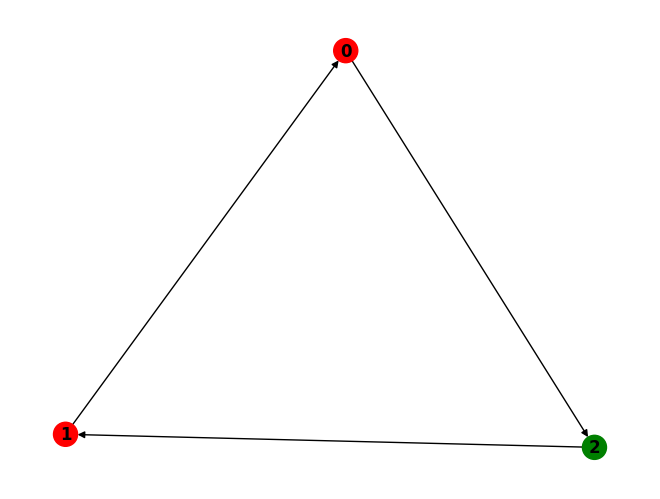

seen: 
{0: {0, 1}, 1: {0, 1}, 2: {0, 1}}
parents = 
{0: {1: 1}, 1: {0: 2}, 2: {0: 0, 1: 0}}
Path found for 2 from 0 = [2, 0]
Path found for 2 from 1 = [2, 0, 1]
{2: {0: [2, 0], 1: [2, 0, 1]}}


In [87]:
run_full_flow(e_triangle) 

### Examples from the photo

In [88]:
e_1 = create_example({0: [2],
       1: [3],
       2: [4],
       3: [4],
       4: [5],
       5: [6]
}, [0, 1], [6])
e_2 = create_example({0: [2],
       1: [3],
       2: [4],
       3: [5],
       4: [6],
       5: [4, 7],
       6: [8],
       7: [9]
}, [0, 1], [8, 9])
e_3 = create_example({0: [2],
       1: [3],
       2: [4],
       3: [5],
       4: [6],
       5: [4, 8],
       6: [8],
}, [0, 1], [8])

Example(graph=<networkx.classes.digraph.DiGraph object at 0x7fbe5d4b19d0>, starting_vertices=[0, 1], final_vertices=[6])


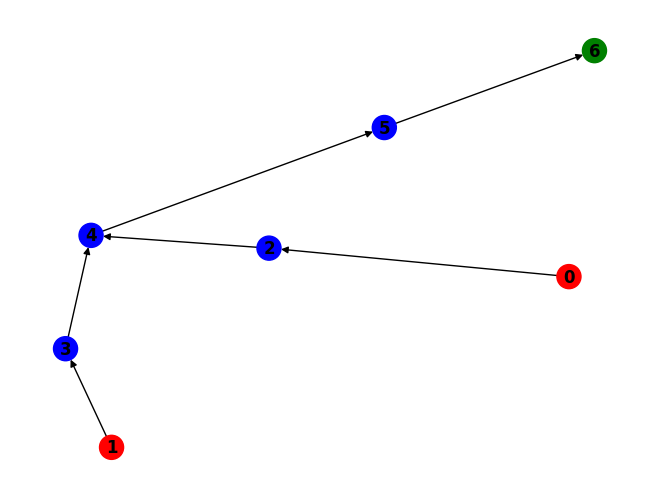

seen: 
{0: {0}, 1: {1}, 2: {0}, 3: {1}, 4: {0, 1}, 5: {0, 1}, 6: {0, 1}}
parents = 
{0: {}, 1: {}, 2: {0: 0}, 3: {1: 1}, 4: {0: 2, 1: 3}, 5: {0: 4, 1: 4}, 6: {0: 5, 1: 5}}
Path found for 6 from 0 = [6, 5, 4, 2, 0]
Path found for 6 from 1 = [6, 5, 4, 3, 1]
{6: {0: [6, 5, 4, 2, 0], 1: [6, 5, 4, 3, 1]}}


In [96]:
run_full_flow(e_1)

Example(graph=<networkx.classes.digraph.DiGraph object at 0x7fbe5d697a90>, starting_vertices=[0, 1], final_vertices=[8, 9])


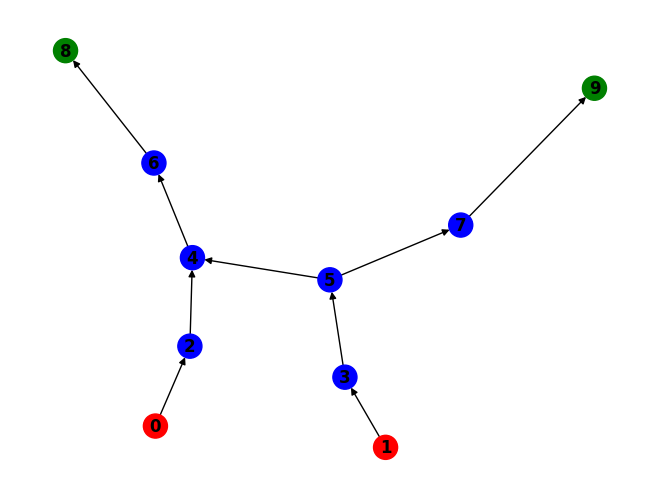

seen: 
{0: {0}, 1: {1}, 2: {0}, 3: {1}, 4: {0, 1}, 5: {1}, 6: {0, 1}, 7: {1}, 8: {0, 1}, 9: {1}}
parents = 
{0: {}, 1: {}, 2: {0: 0}, 3: {1: 1}, 4: {0: 2, 1: 5}, 5: {1: 3}, 6: {0: 4, 1: 4}, 7: {1: 5}, 8: {0: 6, 1: 6}, 9: {1: 7}}
Path found for 8 from 0 = [8, 6, 4, 2, 0]
Path found for 8 from 1 = [8, 6, 4, 5, 3, 1]
Path found for 9 from 1 = [9, 7, 5, 3, 1]
{8: {0: [8, 6, 4, 2, 0], 1: [8, 6, 4, 5, 3, 1]}, 9: {1: [9, 7, 5, 3, 1]}}


In [95]:
run_full_flow(e_2)

Example(graph=<networkx.classes.digraph.DiGraph object at 0x7fbe5dc113d0>, starting_vertices=[0, 1], final_vertices=[8])


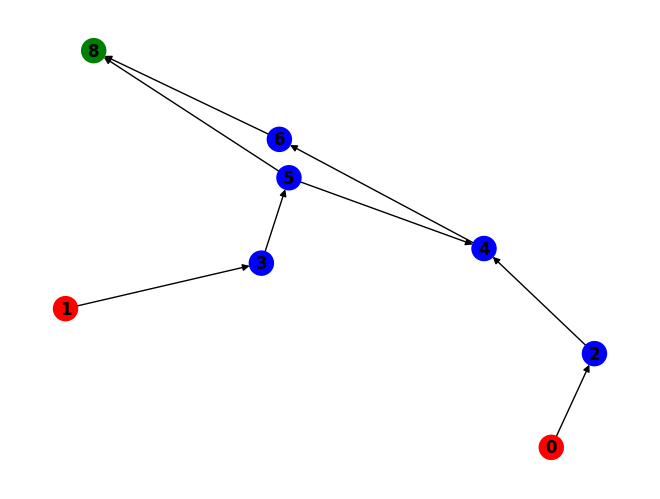

seen: 
{0: {0}, 1: {1}, 2: {0}, 3: {1}, 4: {0, 1}, 5: {1}, 6: {0, 1}, 8: {0, 1}}
parents = 
{0: {}, 1: {}, 2: {0: 0}, 3: {1: 1}, 4: {0: 2, 1: 5}, 5: {1: 3}, 6: {0: 4, 1: 4}, 8: {1: 5, 0: 6}}
Path found for 8 from 0 = [8, 6, 4, 2, 0]
Path found for 8 from 1 = [8, 5, 3, 1]
{8: {0: [8, 6, 4, 2, 0], 1: [8, 5, 3, 1]}}


In [90]:
run_full_flow(e_3)

### Example from the paper

In [91]:
e_paper = create_example(
    {1: [3, 4],
        3: [1, 2, 5],
        4: [1, 2, 6],
        2: [3, 4],
        5: [3],
        6: [4]},
[1, 2], [3, 5, 4, 6])

Example(graph=<networkx.classes.digraph.DiGraph object at 0x7fbe5e19f590>, starting_vertices=[1, 2], final_vertices=[3, 5, 4, 6])


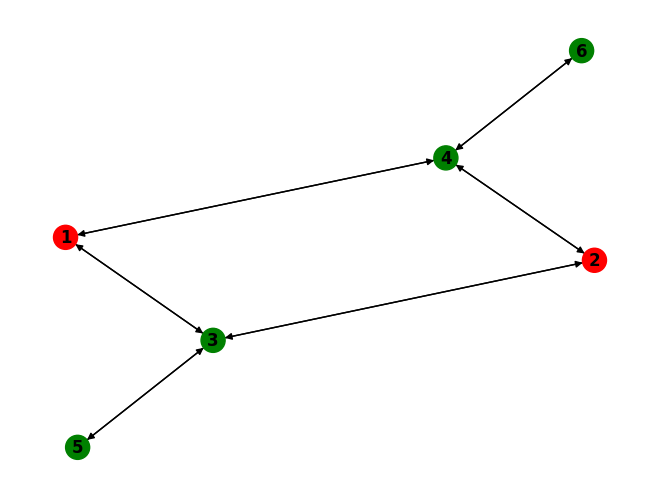

seen: 
{1: {1, 2}, 3: {1, 2}, 4: {1, 2}, 2: {1, 2}, 5: {1, 2}, 6: {1, 2}}
parents = 
{1: {2: 3}, 3: {1: 1, 2: 2}, 4: {1: 1, 2: 2}, 2: {1: 3}, 5: {1: 3, 2: 3}, 6: {1: 4, 2: 4}}
Path found for 3 from 1 = [3, 1]
Path found for 3 from 2 = [3, 2]
Path found for 5 from 1 = [5, 3, 1]
Path found for 5 from 2 = [5, 3, 2]
Path found for 4 from 1 = [4, 1]
Path found for 4 from 2 = [4, 2]
Path found for 6 from 1 = [6, 4, 1]
Path found for 6 from 2 = [6, 4, 2]
{3: {1: [3, 1], 2: [3, 2]}, 5: {1: [5, 3, 1], 2: [5, 3, 2]}, 4: {1: [4, 1], 2: [4, 2]}, 6: {1: [6, 4, 1], 2: [6, 4, 2]}}


In [92]:
run_full_flow(e_paper)